# Setting up pymupdf for image extraction

In [1]:
!pip install pymupdf
!pip install groq
!pip install beautifulsoup4
!pip install openai

  Using cached pymupdf-1.25.2-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 4.0 MB/s eta 0:00:0000:0100:01
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
Using cached soupsieve-2.6-py3-none-any.whl (36 kB)


In [2]:
import fitz
import io
import base64
import tempfile
from bs4 import BeautifulSoup
from IPython.display import Image, display

In [3]:
def convert_pdf_page_to_image_stream(pdf_bytes, page_number, zoom=2):
    """
    Convert a specific page of a PDF to an image stream.

    Args:
    pdf_bytes (bytes): bytes of PDF file.
    page_number (int): Page number to convert to image (0-based index).
    zoom (float): Zoom factor for the image. Higher values mean better quality.

    Returns:
    BytesIO: The image object of the PDF page as a BytesIO stream.
    """
    document = fitz.open(stream=pdf_bytes, filetype="pdf")
    page = document.load_page(page_number)

    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)

    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
        tmp_file_name = tmp_file.name
        pix.save(tmp_file_name)

    with open(tmp_file_name, "rb") as image_file:
        image_stream = io.BytesIO(image_file.read())

    image_stream.seek(0)
    document.close()

    return image_stream

In [4]:
pdf_file = '/content/JD Buisness Analyst.pdf'
page_number = 1
zoom_factor = 2
with open(pdf_file, "rb") as f:
    pdf_bytes = f.read()

In [5]:
image_stream = convert_pdf_page_to_image_stream(pdf_bytes=pdf_bytes, page_number=page_number, zoom = zoom_factor)

In [6]:
# save the extracted bytes as png
output_image_file = f"page_{page_number}.png"

with open(output_image_file, "wb") as output_file:
        output_file.write(image_stream.read())

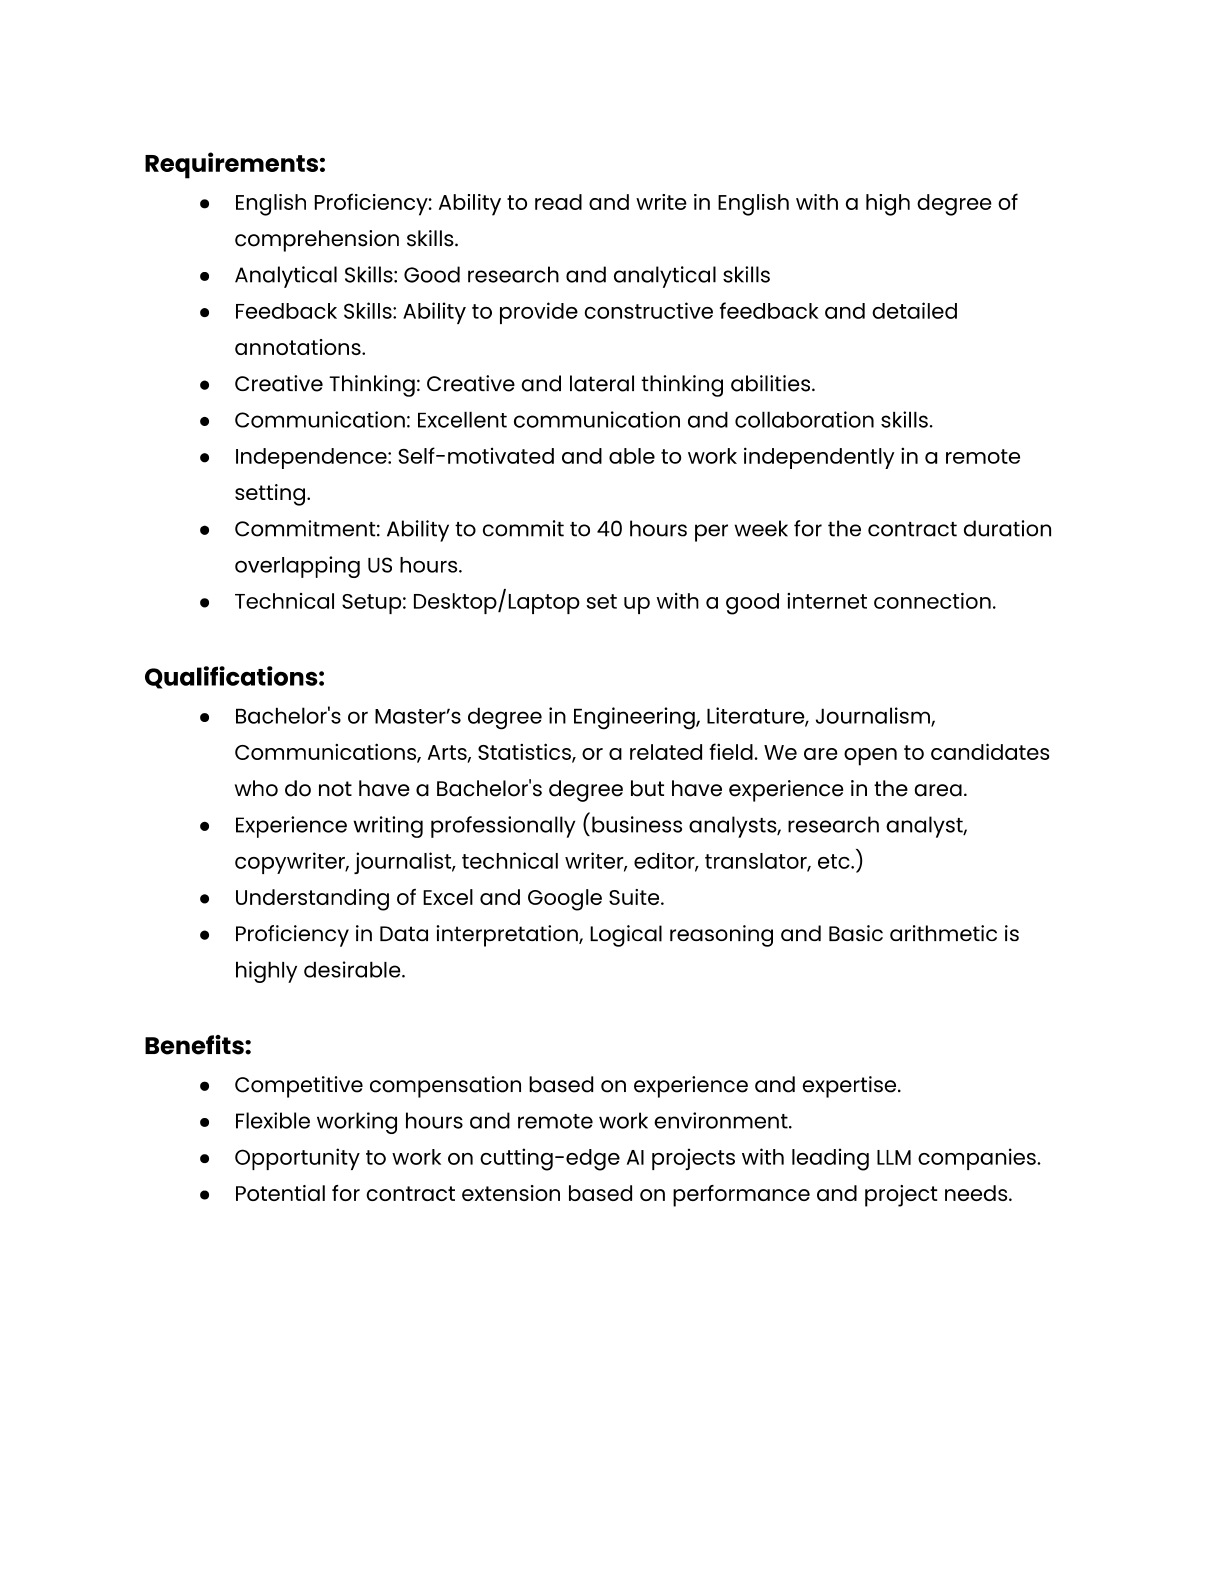

In [7]:
# Display the saved image
display(Image(filename=output_image_file))

In [8]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = output_image_file

# Getting the base64 string
base64_image = encode_image(image_path)

# Text extraction Using Groq

In [9]:
from groq import Groq
from google.colab import userdata

In [10]:
# Setting up the client
groq_api = userdata.get('GROQ_API_KEY')
client = Groq(api_key=groq_api)

In [11]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",       # role system currently not supported by groq
            "content": [
                {"type": "text", "text": "Summarize the image."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llama-3.2-90b-vision-preview",
)

summary = chat_completion.choices[0].message.content

In [12]:
print(textInImage)

The image presents a job description for an AI Content Analyst position at LLM, detailing the requirements and qualifications for the role.

**Requirements:**

* English Proficiency: Ability to read and write in English with a high degree of comprehension skills.
* Analytical Skills: Good research and analytical skills.
* Feedback Skills: Ability to provide constructive feedback and detailed annotations.
* Creative Thinking: Creative and lateral thinking abilities.
* Communication: Excellent communication and collaboration skills.
* Independence: Self-motivated and able to work independently in a remote setting.
* Commitment: Ability to commit to 40 hours per week for the contract duration overlapping US hours.
* Technical Setup: Desktop/Laptop set up with a good internet connection.

**Qualifications:**

* Bachelor's or Master's degree in Engineering, Literature, Journalism, Communications, Arts, Statistics, or a related field.
* Experience writing professionally (business analysts, r

# Text extraction Using GPT4

In [13]:
from openai import OpenAI

In [14]:
openai_api = userdata.get('OPENAI_API_KEY')

client = OpenAI(api_key=openai_api)

In [15]:
completion = client.chat.completions.create(
  model= "gpt-4o-mini",
  messages = [
            {
                "role": "system",
                "content": "Summarize the image."
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
  max_tokens= 4095
)

textInImage = completion.choices[0].message